<a href="https://colab.research.google.com/github/ulfmagnetics/cover-art-classifier/blob/main/cover_art_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Album Art Classification using a neural network

This notebook trains a neural network to classify album cover images in several distinct genres -- *doom metal* and *classical*. We'll download thumbnails of album covers using the [Cover Art Archive](https://coverartarchive.org/)'s API, then train our model to tell covers in the different genres apart from one another.

I'm doing this work as part of completing Chapter 2 of the [fast.ai course](https://course.fast.ai/).

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.5 MB/s 
     |████████████████████████████████| 1.2 MB 13.5 MB/s 
     |████████████████████████████████| 189 kB 7.7 MB/s 
     |████████████████████████████████| 48 kB 2.2 MB/s 
     |████████████████████████████████| 55 kB 1.2 MB/s 
     |████████████████████████████████| 51 kB 173 kB/s 
     |████████████████████████████████| 561 kB 35.1 MB/s 
     |████████████████████████████████| 130 kB 34.7 MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *

I'm using the `colab-env` package to pull environment variables from a file in my Google Drive. See [this notebook](https://colab.research.google.com/github/apolitical/colab-env/blob/master/colab_env_testbed.ipynb) for more details.

In [3]:
#hide
!pip install colab-env --upgrade
import colab_env

  Created wheel for colab-env: filename=colab_env-0.2.0-py3-none-any.whl size=3838 sha256=64786255f7fc81ce8466eadebfa06793e1f4b930f7abfa02ac40444ce6a68fed
  Stored in directory: /root/.cache/pip/wheels/bb/ca/e8/3d25b6abb4ac719ecb9e837bb75f2a9b980430005fb12a9107
Successfully built colab-env
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
#hide
!pip install musicbrainzngs
from musicbrainzngs import *  

In [5]:
import os
set_useragent(os.getenv('MUSICBRAINZNGS_USERAGENT_NAME'), '0.1', contact=os.getenv('MUSICBRAINZNGS_USERAGENT_CONTACT'))

In [6]:
from math import ceil

debug = os.getenv('ALBUM_ART_CLASSIFIER_DEBUG')

image_quota = 50 if debug else 500
max_attempts = 100 if debug else 1000
page_size = 10 if debug else 100

tags = ['doom metal', 'classical']
path = Path('album_covers')

if not path.exists():
  path.mkdir()
  for tag in tags:
    print(u"*** tag: {tag}".format(tag=tag))
    dest = (path/tag)
    urls = []

    for page in range(0, ceil(max_attempts/page_size)):
      result = search_releases(tag=tag, limit=page_size, offset=page*page_size)
      for release in result['release-list']:
        mbid = release['id']
        if debug:
          print(u"{id}: {artist} - {title}".format(id=mbid, artist=release['artist-credit'][0]['name'], title=release['title']))
        try:
          image_data = get_image_list(mbid)
          for image in image_data["images"]:
            if "Front" in image["types"] and image["approved"]:
                url = image["thumbnails"]["large"]
                if debug:
                  print(u"     --> {url}".format(url=url))
                urls.append(url)
                break
        except Exception as err:
          if debug:
            print(err)


      if len(urls) >= image_quota:
        print("     --> image quota reached for {tag}".format(tag=tag))
        break

    download_images(dest, urls=urls)


*** tag: doom metal
     --> image quota reached for doom metal
*** tag: classical
     --> image quota reached for classical


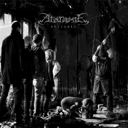

In [7]:
fns = get_image_files(path)
img = Image.open(fns[0])
img.to_thumb(128,128)

In [8]:
failed = verify_images(fns)
failed

(#0) []

In [9]:
failed.map(Path.unlink)

(#0) []

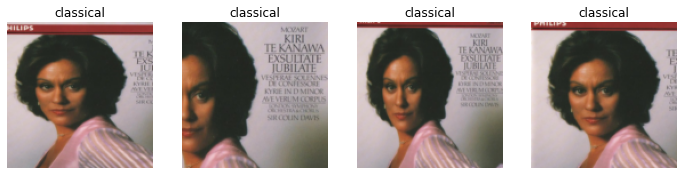

In [10]:
# creates a template/factory for generating DataLoaders for the album cover images
covers = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(128, min_scale=0.3),
)
dls = covers.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


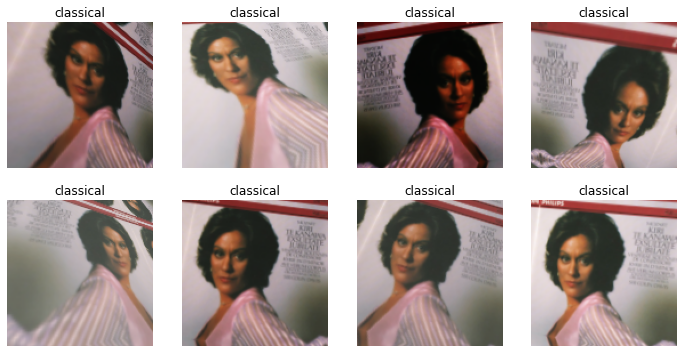

In [11]:
# use aug_transforms to augment the data (via a batch transform)
covers = covers.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = covers.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [12]:
covers = covers.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = covers.dataloaders(path)

In [16]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,0.944582,0.385037,0.151376,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.479390,0.313874,0.146789,00:14
1,0.407306,0.219152,0.087156,00:15
2,0.339019,0.226044,0.082569,00:15
3,0.287682,0.203079,0.105505,00:14
4,0.237055,0.177882,0.073394,00:14
5,0.206500,0.182996,0.068807,00:14


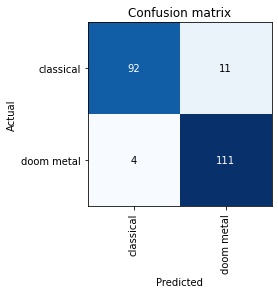

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Looks like the best I can do with this network (and my current skill level with machine learning) is differentiate between doom metal and classical album covers a little less than 95% of the time. Not perfect, but pretty good!

I guess some classical album covers do look a little bit doom-y, like this one:

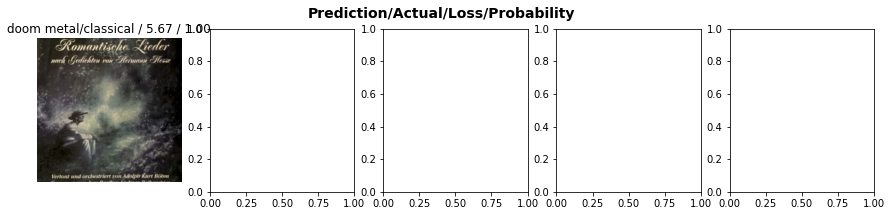

In [19]:
interp.plot_top_losses(5, nrows=1)

Now we can export and download the model, with the ultimate goal being to serve the model publicly via Binder (or a similar platform).

In [21]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [22]:
from google.colab import files
files.download('export.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>